In [1]:
import numpy as np
import sys
import xarray as xr
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path

In [213]:
import numpy as np
from pyresample.geometry import SwathDefinition

In [223]:
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

In [609]:
from pyresample import kd_tree, geometry

In [2]:
import dask
dask.config.set({'temporary_directory': '/tmp'})

from dask.distributed import Client, progress
client = Client(processes=False, n_workers=1, threads_per_worker=12,memory_limit='24GB')
client

Client Scheduler: inproc://137.78.251.47/97211/1 Dashboard: http://137.78.251.47:8787/status,Cluster Workers: 1 Cores: 12 Memory: 22.35 GiB


In [3]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:

sys.path.append('/home/ifenty/ECCOv4-py')
#sys.path.append('/Users/ifenty/git_repos/ECCO-GROUP/ECCOv4-py')
import ecco_v4_py as ecco

In [11]:
sys.path.append('/home/ifenty/git_repos_others/oceanspy/')
import oceanspy as ospy

In [7]:
def load_ecco_fields_from_nc(ecco_files):
    time_start=time.time()

    ecco_fields = xr.open_mfdataset(ecco_files, parallel=True, data_vars='minimal',\
                                  coords='minimal',compat='override', concat_dim='time')
    
    tt = time.time() - time_start    
    print(tt / len(ecco_files))
    print(time.time() - time_start)
    return ecco_fields

In [242]:
def make_natl_plot():
    plt.figure(figsize=[10,10])
    ax = plt.axes(projection = ccrs.Mercator())  # create a set of axes with Mercator projection
    ax.add_feature(cf.COASTLINE)                 # plot some data on them
    ax.set_title("Title")                        # label it
    ax.set_xlim([-50, 0])
    ax.set_ylim([-90, 90])
    ax.set_extent([-90, 0, 25, 45], ccrs.PlateCarree())
    ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '110m', 
                                          edgecolor='face', facecolor='g'))
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    return ax

In [243]:
## Load the model grid
#grid_dir= Path('/Users/ifenty/inSync Share/grid_ECCOV4r4')
grid_dir = Path('/home/ifenty/data/grids/grid_ECCOV4r4/')
ecco_grid = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
xgcm_grid = ecco.get_llc_grid(ecco_grid)

In [5]:
velocity_dataset_dir = Path('/ecco_nfs_1/shared/ECCOV4r4/Release4/final_delivered/final_delivered/native/mon_mean/OCEAN_VELOCITY')

In [6]:
velocity_files = np.sort(list(velocity_dataset_dir.glob('*nc')))

In [8]:
import time

In [9]:
u = load_ecco_fields_from_nc(velocity_files)

0.1968639470063723
61.421921730041504


In [908]:
list(u.data_vars)

['UVEL', 'VVEL', 'WVEL']

# Isabela's points

In [244]:
pts = dict()
pts[1] = [-70.2,40.3]
pts[2] = [-68.0, 37.1]
pts[3] = [-66.4, 35]
pts[4] = [-35.9, 35]
pts[5] = [-7, 35]


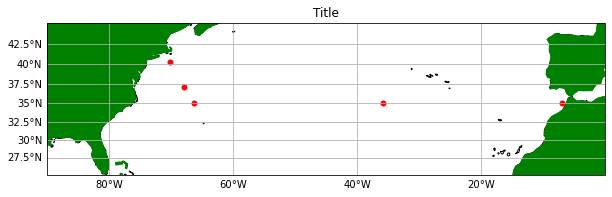

In [246]:
ax = make_natl_plot()
for pt in pts.keys():
    ax.plot(pts[pt][0],pts[pt][1], 'ro',markersize=5,transform=ccrs.PlateCarree())

In [823]:
# Use oceanspy to generate a set of lat/lon points along 
# Isabela's lines.  

# .. first calculate the distance between points
#https://oceanspy.readthedocs.io/en/latest/generated/oceanspy.utils.great_circle_path.html
# points 1 and 2
path_12 = ospy.utils.great_circle_path(pts[1][1], pts[1][0], pts[2][1], pts[2][0])
# points 1 and 3
path_13 = ospy.utils.great_circle_path(pts[1][1], pts[1][0], pts[3][1], pts[3][0])
# points 3 and 4
path_34 = ospy.utils.great_circle_path(pts[3][1], pts[3][0], pts[4][1], pts[4][0])
# points 4 and 5
path_45 = ospy.utils.great_circle_path(pts[4][1], pts[4][0], pts[5][1], pts[5][0])
# points 3 and 5
path_35 = ospy.utils.great_circle_path(pts[3][1], pts[3][0], pts[5][1], pts[5][0])

# outputs lats, lons, and distances [km]
print(path_12)
print(path_13)
print(path_34)
print(path_45)

# distance between points 1 and 2 is 403.77 km (verified)

(array([40.3, 37.1]), array([-70.2, -68. ]), array([  0.        , 403.77020075]))
(array([40.3, 35. ]), array([-70.2, -66.4]), array([  0.        , 677.49572306]))
(array([35, 35]), array([-66.4, -35.9]), array([   0.        , 2767.12655654]))
(array([35, 35]), array([-35.9,  -7. ]), array([   0.        , 2623.04659466]))


In [824]:
# redo the above, but this time ask for points every x km
x=5 # km
path_12_lats, path_12_lons, path_12_dist = ospy.utils.great_circle_path(pts[1][1], pts[1][0], pts[2][1], pts[2][0], x)
path_13_lats, path_13_lons, path_13_dist = ospy.utils.great_circle_path(pts[1][1], pts[1][0], pts[3][1], pts[3][0], x)

delta_x=.5 # to go cartesian (not great circle) then delta is specified in the same
# units as the x and y (in this case degrees)

path_34_lats, path_34_lons, path_34_dist = ospy.utils.cartesian_path(pts[3][1], pts[3][0],pts[4][1]+0.01, pts[4][0]+0.01,delta=delta_x)
path_45_lats, path_45_lons, path_45_dist = ospy.utils.cartesian_path(pts[4][1], pts[4][0],pts[5][1]+0.01, pts[5][0]+0.01,delta=delta_x)
path_35_lats, path_35_lons, path_35_dist = ospy.utils.cartesian_path(pts[3][1], pts[3][0],pts[5][1]+0.01, pts[5][0]+0.01,delta=delta_x)

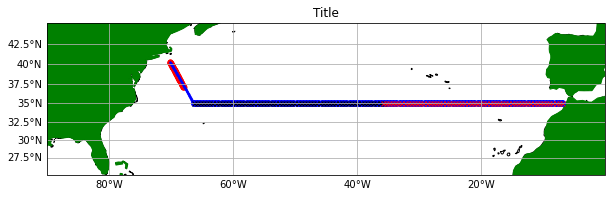

In [828]:
ax = make_natl_plot()
ax.plot(path_12_lons, path_12_lats, 'ro',markersize=5,transform=ccrs.PlateCarree())
ax.plot(path_13_lons, path_13_lats, 'b.',markersize=2,transform=ccrs.PlateCarree())
ax.plot(path_35_lons, path_35_lats, 'bo',markersize=6,transform=ccrs.PlateCarree())

ax.plot(path_34_lons, path_34_lats, 'kx',markersize=5,transform=ccrs.PlateCarree())
ax.plot(path_45_lons, path_45_lats, 'rx',markersize=5,transform=ccrs.PlateCarree())


# ECCO

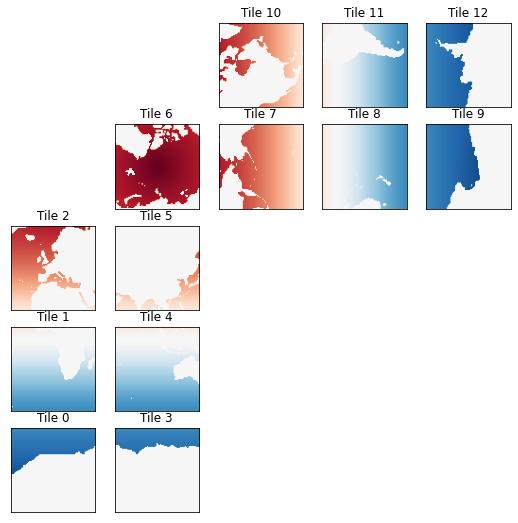

In [70]:
ecco.plot_tiles(ecco_grid.YC*ecco_grid.maskC[0]);

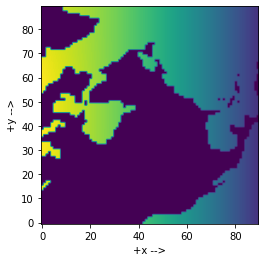

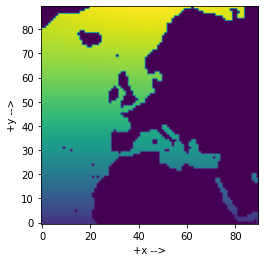

In [73]:
ecco.plot_tile(ecco_grid.YC[10]*ecco_grid.maskC[0,10]);
ecco.plot_tile(ecco_grid.YC[2]*ecco_grid.maskC[0,2]);

```AngleCS, AngleSN (cos(phi) and sin(phi), where phi is the angle)

rotation: AngleCS*uc - AngleSN*vc, and AngleSN*uc + AngleCN*vc. uc,vc,
are the velocity components averaged to the center of grid cell (C-points).


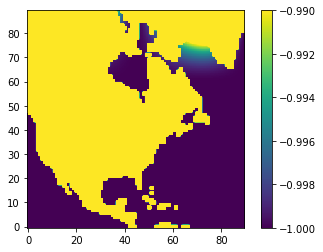

In [212]:
plt.imshow(np.rot90(ecco_grid.SN[10,:]*ecco_grid.maskC[0,10]), origin='lower', vmin=-1, vmax=-.99);plt.colorbar()

around 35N, the ECCO grid aligned with parallels and meridians

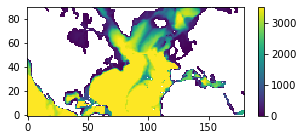

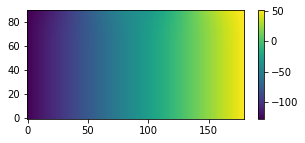

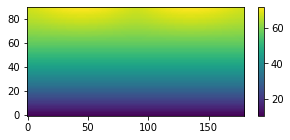

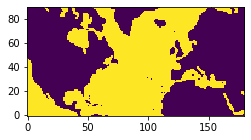

In [910]:
# make north atlantic mask by rotating tile 10 ninety degrees to the right and 
# concatenating it with tile 2

# hFacC and the wet/dry mask
hFacC_atl = np.zeros([50, 90, 180])
maskC_atl = np.zeros([50, 90, 180])

for k in range(50):
    hFacC_atl[k, :,:] = np.hstack([np.rot90(ecco_grid.hFacC[k,10]), ecco_grid.hFacC[k,2]])
    maskC_atl[k, :,:] = np.hstack([np.rot90(ecco_grid.maskC[k,10]), ecco_grid.maskC[k,2]])
    
# mask land points in depth map
depth_atl = np.hstack([np.rot90(ecco_grid.Depth[10]), ecco_grid.Depth[2]])
depth_atl = np.where(maskC_atl[0], depth_atl, np.nan)

# the lons and lats
XC_atl = np.hstack([np.rot90(ecco_grid.XC[10]), ecco_grid.XC[2]])
YC_atl = np.hstack([np.rot90(ecco_grid.YC[10]), ecco_grid.YC[2]])

# plot mask and depth
plt.figure(figsize=[5,2])
plt.imshow(depth_atl, origin='lower', interpolation='none',vmin=0,vmax=3500);plt.colorbar();
plt.figure(figsize=[5,2])
plt.imshow(XC_atl, origin='lower', interpolation='none');plt.colorbar();

plt.figure(figsize=[5,2])
plt.imshow(YC_atl, origin='lower', interpolation='none');plt.colorbar();
plt.figure(figsize=[5,2])
plt.imshow(maskC_atl[0], origin='lower', interpolation='none')


In [911]:
# do the same for hFacW and hFacS
hFacW_atl = np.zeros([50, 90, 180])
hFacS_atl = np.zeros([50, 91, 180])

for k in range(50):
    hFacW_atl[k, :90, :90] = np.rot90(ecco_grid.hFacS[k, 10,:])
    hFacW_atl[k, :90, 90:] = ecco_grid.hFacW[k, 2,:]

    hFacS_atl[k, 1:91, :90] = np.rot90(ecco_grid.hFacW[k, 10,:])
    hFacS_atl[k, 0:90, 90:] = ecco_grid.hFacS[k, 2,:]

Text(0.5, 1.0, 'hFacS : +y direction')

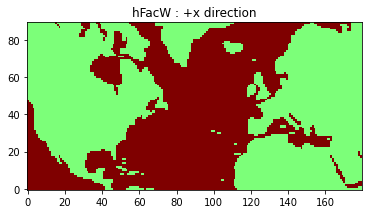

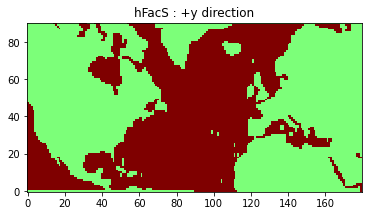

In [912]:
plt.imshow(hFacW_atl[0], origin='lower', interpolation='none',  cmap='jet', vmin=-.1, vmax=.1)
plt.title('hFacW : +x direction')
plt.figure()
plt.imshow(hFacS_atl[0], origin='lower', interpolation='none', cmap='jet', vmin=-.1, vmax=.1)
plt.title('hFacS : +y direction')

# 2004-2014 time mean of ECCO velocity fields

In [723]:
period_start = 144
period_end   = 144+12*10-1

print(u.time[period_start].values)
print(u.time[period_end].values)

uvel_period = u.UVEL[period_start:period_end,:]
vvel_period = u.VVEL[period_start:period_end,:]

print(uvel_period.time[0].values)
print(uvel_period.time[-1].values)

2004-01-16T12:00:00.000000000
2013-12-16T12:00:00.000000000
2004-01-16T12:00:00.000000000
2013-11-16T00:00:00.000000000


In [724]:
uvel_period_mean = uvel_period.mean(dim='time')
vvel_period_mean = vvel_period.mean(dim='time')

In [725]:
uvel_period_mean = uvel_period_mean.compute()
vvel_period_mean = vvel_period_mean.compute()

# Combine the uvels and vvels into a single north altantic grid

In [726]:
k = 0
uvel_atl = np.zeros([50, 90, 180])
vvel_atl = np.zeros([50, 91, 180])

for k in range(50):
    # on model 'u' points
    uvel_atl[k,:90, :90] = np.rot90(vvel_period_mean[k, 10,:])
    uvel_atl[k,:90, 90:] = uvel_period_mean[k, 2,:]

    # on model 'v' points
    vvel_atl[k,1:91, :90] = -np.rot90(uvel_period_mean[k, 10,:])
    vvel_atl[k,:90, 90:]  = vvel_period_mean[k, 2,:]

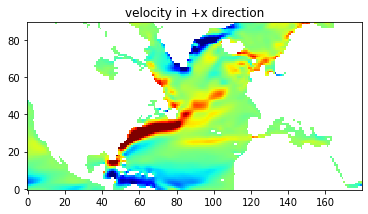

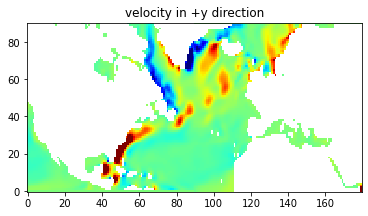

In [710]:
k=10
plt.title('velocity in +x direction')
plt.imshow(uvel_atl[k], origin='lower', interpolation='none',
           cmap='jet', vmin=-.1, vmax=.1)
plt.figure();
plt.title('velocity in +y direction')
plt.imshow(vvel_atl[k], origin='lower', interpolation='none',
           cmap='jet', vmin=-.1, vmax=.1)

In [913]:
print(uvel_atl.shape)
print(vvel_atl.shape)

# vvel has one more because of the way the llc grid is organized

(50, 90, 180)
(50, 91, 180)


In [914]:
# set nan points to zero
uvel_atl = np.where(np.isnan(uvel_atl), 0, uvel_atl)
vvel_atl = np.where(np.isnan(vvel_atl), 0, vvel_atl)

print(uvel_atl.shape)
print(vvel_atl.shape)

(50, 90, 180)
(50, 91, 180)


In [915]:
# bring uvel and vvel to the grid cell center (instead of at the model u and v points)
# of the c-grid

uvel_atl_c = np.zeros([50, 90, 180])
vvel_atl_c = np.zeros([50, 90, 180])

for k in range(50):
    uvel_atl_c[k,:,:179] = 0.5*(uvel_atl[k,:,0:-1] + uvel_atl[k,:,1:])
    uvel_atl_c[k] = np.where(maskC_atl[k] > 0, uvel_atl_c[k], np.nan)

for k in range(50):
    vvel_atl_c[k] = 0.5*( vvel_atl[k,:90,:] + vvel_atl[k,1:,:] )
    vvel_atl_c[k] = np.where(maskC_atl[k] > 0, vvel_atl_c[k], np.nan)

print(uvel_atl_c.shape)
print(vvel_atl_c.shape)
print(maskC_atl.shape)

(50, 90, 180)
(50, 90, 180)
(50, 90, 180)


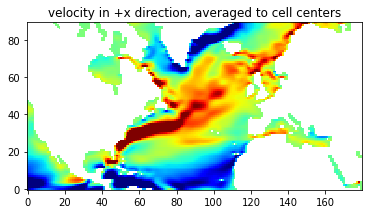

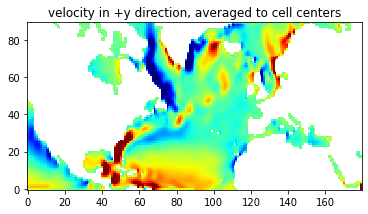

In [916]:
k=0
plt.title('velocity in +x direction, averaged to cell centers')
plt.imshow(uvel_atl_c[k], origin='lower', interpolation='none',
           cmap='jet', vmin=-.1, vmax=.1)

plt.figure();
plt.title('velocity in +y direction, averaged to cell centers')
plt.imshow(vvel_atl_c[k], origin='lower', interpolation='none',
           cmap='jet', vmin=-.1, vmax=.1)

# prepare for interpolation

In [918]:
# determine which points are wet at each depth level
# and pull out the lons and lats of those points
# and create a 'swath def' object for the wet points at
# each depth level which will be used later to interpolate

atl_wet_ins_k = dict()
wet_lons_k = dict()
wet_lats_k = dict()
ecco_swath_wet_def_k = dict()

for k in range(50):
    atl_wet_ins_k[k] = np.where(maskC_atl[k].ravel() > 0)[0]
    print(f'number of wet points at level {k} : {len(atl_wet_ins_k[k])}')

    wet_lons_k[k] = XC_atl.ravel()[atl_wet_ins_k[k]]
    wet_lats_k[k] = YC_atl.ravel()[atl_wet_ins_k[k]]

    ecco_swath_wet_def_k[k] = SwathDefinition(lons= wet_lons_k[k], lats=wet_lats_k[k])

# create a 'swath def' object for all ecco points. used later for interpolation
ecco_swath_all_def = SwathDefinition(lons= XC_atl.ravel(), 
                                     lats= YC_atl.ravel())

number of wet points at level 0 : 7492
number of wet points at level 1 : 7492
number of wet points at level 2 : 7347
number of wet points at level 3 : 7246
number of wet points at level 4 : 7166
number of wet points at level 5 : 7071
number of wet points at level 6 : 7005
number of wet points at level 7 : 6934
number of wet points at level 8 : 6879
number of wet points at level 9 : 6813
number of wet points at level 10 : 6733
number of wet points at level 11 : 6671
number of wet points at level 12 : 6608
number of wet points at level 13 : 6540
number of wet points at level 14 : 6477
number of wet points at level 15 : 6392
number of wet points at level 16 : 6325
number of wet points at level 17 : 6224
number of wet points at level 18 : 6139
number of wet points at level 19 : 6023
number of wet points at level 20 : 5907
number of wet points at level 21 : 5800
number of wet points at level 22 : 5716
number of wet points at level 23 : 5654
number of wet points at level 24 : 5598
number of 

In [919]:
# get the lat/lon min/max for the atl box
print(XC_atl[:].min(), XC_atl[:].max())
print(YC_atl[:].min(), YC_atl[:].max())

-127.83792 51.837925
10.458642 71.83288


# do a test interpolation to a higher res atl grid

In [921]:
# set up a dummy lon/lat grid that has the same extent as the original ecco atl region
# this is just to test that the interpolation is working -- interpolate the ecco uvel 
# and vvel to this higher resolution grid -- it should look the same
dummy_lons, dummy_lats = np.meshgrid(np.linspace(-117, 52,180*10),
                                     np.linspace(10,72,90*10))

In [608]:
dummy_swath_def = SwathDefinition(lons=dummy_lons.ravel(), lats=dummy_lats.ravel())

In [610]:
mask_hr = kd_tree.resample_nearest(ecco_swath_all_def, maskC_atl[0].ravel(), 
                                  dummy_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)

depth_hr = kd_tree.resample_nearest(ecco_swath_all_def, depth_atl.ravel(), 
                                  dummy_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)

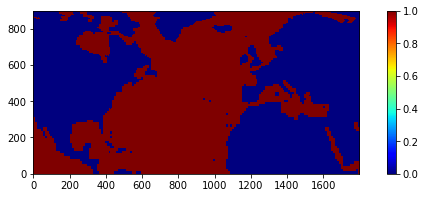

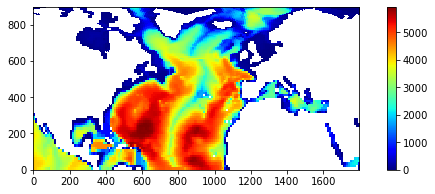

In [611]:
mask_hr = np.reshape(mask_hr, dummy_lats.shape)
plt.figure(figsize=[10,3])
plt.imshow(mask_hr, cmap='jet', origin='lower', interpolation='none');plt.colorbar()

depth_hr = np.reshape(depth_hr, dummy_lats.shape)
plt.figure(figsize=[10,3])
plt.imshow(depth_hr, cmap='jet', origin='lower', interpolation='none');plt.colorbar()

## interpolate the model uvel and vvel to the higher resolution grid

In [739]:
k=0
vvel_wet = vvel_atl_c[k].ravel()[atl_wet_ins_k[k]]
uvel_wet = uvel_atl_c[k].ravel()[atl_wet_ins_k[k]]

vvel_test_result = kd_tree.resample_nearest(ecco_swath_wet_def_k[0], vvel_wet, 
                                  dummy_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)

uvel_test_result = kd_tree.resample_nearest(ecco_swath_wet_def_k[0], uvel_wet, 
                                  dummy_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)

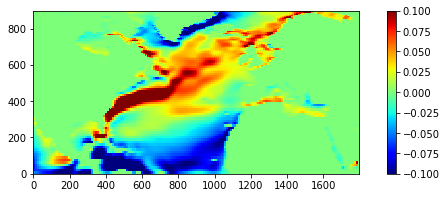

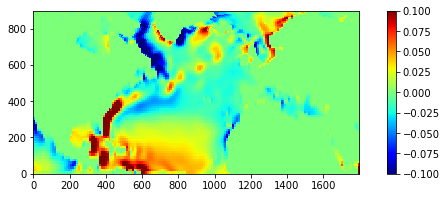

In [740]:
vvel_test_result = np.reshape(vvel_test_result, dummy_lats.shape)
vvel_test_result = vvel_test_result*result_mask

uvel_test_result = np.reshape(uvel_test_result, dummy_lats.shape)
uvel_test_result = uvel_test_result*result_mask

plt.figure(figsize=[10,3])
plt.imshow(uvel_test_result, cmap='jet', origin='lower',
           interpolation='none', vmin=-.1, vmax=.1);plt.colorbar()

plt.figure(figsize=[10,3])
plt.imshow(vvel_test_result, cmap='jet', origin='lower',
           interpolation='none', vmin=-.1, vmax=.1);plt.colorbar()


results look fine, proceed with interpolation to isabela's lines

# prepare swath def objects for two lines: pts 1-3, and 3-5

In [829]:
path_13_swath_def = SwathDefinition(lons=path_13_lons, lats=path_13_lats)
path_35_swath_def = SwathDefinition(lons=path_35_lons, lats=path_35_lats)

interpolate the model depth to those lines

In [922]:
depth_line13 = -1*kd_tree.resample_nearest(ecco_swath_all_def, depth_atl, 
                                  path_13_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)
depth_line35 = -1*kd_tree.resample_nearest(ecco_swath_all_def, depth_atl, 
                                  path_35_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)

Text(0.5, 0, 'degrees')

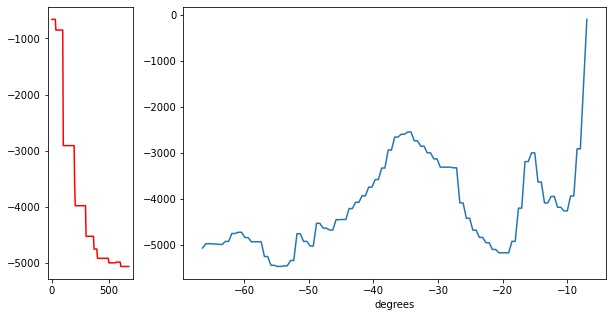

In [928]:
fig,axs=plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 5]}, figsize=[10,5]);
axs[0].plot(path_13_dist,depth_line13,'r')
axs[1].set_xlabel("km")
axs[1].plot(path_35_lons,depth_line35)
axs[1].set_xlabel("degrees")

create variables for the u and vvel fields along the lines

In [929]:
# line 1-3 needs uvel (east) and vvel (north) components
# because both project onto the line
uvel_line13 = np.zeros([50, len(path_13_lats)])
vvel_line13 = np.zeros([50, len(path_13_lats)])

# line 3-5 only has vvel (only northward component)
vvel_line35 = np.zeros([50, len(path_35_lats)])

mask_line13 = np.zeros([50, len(path_13_lats)])
mask_line35 = np.zeros([50, len(path_35_lats)])

print(vvel_line13.shape)

(50, 136)


In [930]:
# Loop through each depth level, interplation uvel and vvel to the lines

for k in range(50):
    vvel_wet = vvel_atl_c[k].ravel()[atl_wet_ins_k[k]]
    uvel_wet = uvel_atl_c[k].ravel()[atl_wet_ins_k[k]]
    
    vvel_line13[k] = kd_tree.resample_nearest(ecco_swath_wet_def_k[k], vvel_wet, 
                                      path_13_swath_def, radius_of_influence=120000,
                                      epsilon=0.5)

    uvel_line13[k] = kd_tree.resample_nearest(ecco_swath_wet_def_k[k], uvel_wet, 
                                      path_13_swath_def, radius_of_influence=120000,
                                      epsilon=0.5)
    
    vvel_line35[k] = kd_tree.resample_nearest(ecco_swath_wet_def_k[k], uvel_wet, 
                                  path_35_swath_def, radius_of_influence=120000,
                                  epsilon=0.5)
    
    mask_line13[k] = kd_tree.resample_nearest(ecco_swath_all_def, maskC_atl[k], 
                                      path_13_swath_def, radius_of_influence=120000,
                                      epsilon=0.5)
    
    mask_line35[k] = kd_tree.resample_nearest(ecco_swath_all_def, maskC_atl[k], 
                                      path_35_swath_def, radius_of_influence=120000,
                                      epsilon=0.5)

In [931]:
# make nans where the mask is zero
mask_line13 = np.where(mask_line13 == 1, 1, np.nan)
mask_line35 = np.where(mask_line35 == 1, 1, np.nan)

In [903]:
# project the x and y velocity components onto the line W line
# angle between points 1 and 3 is 300 degrees, or -60 degrees
# a little unit circle helped here

print(np.sin(np.pi/6))
print(np.sin(np.pi/3))

pvel_line13_rotated = vvel_line13*0.5     # sin(pi/6)
pvel_line13_rotated = pvel_line13_rotated+uvel_line13*0.8666 # sin(pi/3)

0.49999999999999994
0.8660254037844386


# plot the uvel and vvel along the line 1-3

Text(0.5, 1.0, 'vvel along line')

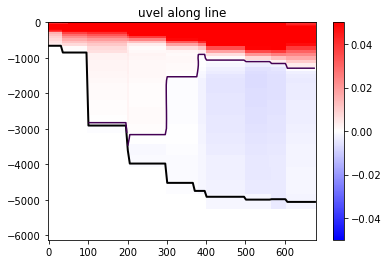

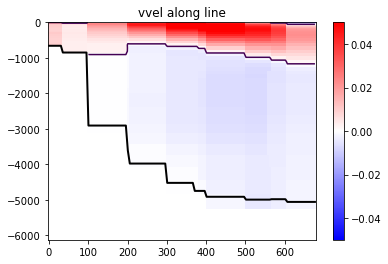

In [867]:
plt.pcolormesh(path_13_dist, ecco_grid.Z,
               uvel_line13*mask_line13, cmap='bwr',
               vmin=-.05, vmax=.05)
plt.colorbar()
plt.plot(path_13_dist, depth_line13,'k-',linewidth=2)
plt.contour(path_13_dist, ecco_grid.Z, uvel_line13*mask_line13,
            levels=[0], color='k')
plt.title('uvel along line')

plt.figure()
plt.pcolormesh(path_13_dist, ecco_grid.Z, 
               vvel_line13*mask_line13, cmap='bwr',
               vmin=-.05, vmax=.05)
plt.colorbar()
plt.plot(path_13_dist, depth_line13,'k-',linewidth=2)
plt.contour(path_13_dist, ecco_grid.Z, vvel_line13*mask_line13,
            levels=[0], color='k')
plt.title('vvel along line')

## plot the velocity perpendicular to the 1-3 line

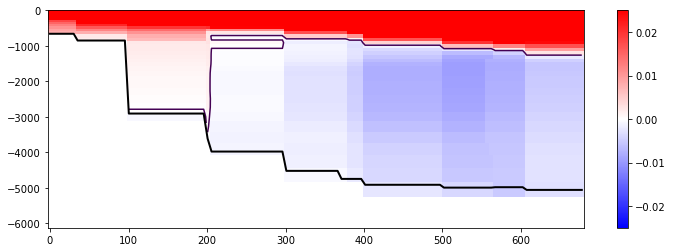

In [902]:
plt.figure(figsize=[12,4])
plt.pcolormesh(path_13_dist, ecco_grid.Z, 
               pvel_line13_rotated*mask_line13, cmap='bwr',
               vmin=-.025, vmax=.025)
plt.colorbar()
plt.contour(path_13_dist, ecco_grid.Z, pvel_line13_rotated*mask_line13,
            levels=[0], color='k', linewidth=.5)
plt.plot(path_13_dist, depth_line13,'k-',linewidth=2)

#plt.title('velocity perpendicular to line between points 1-3')
#plt.xlabel('km')

## Plot the northward velocity along the 35N line

Text(0.5, 0, 'degrees E')

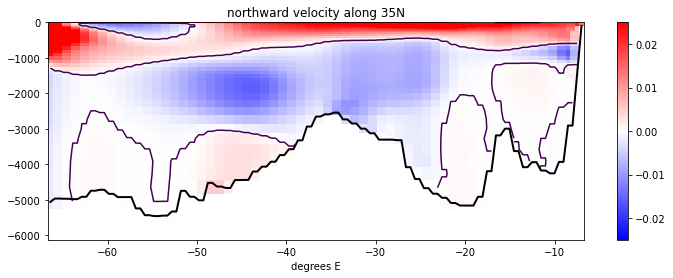

In [901]:
plt.figure(figsize=[12,4])
plt.pcolormesh(path_35_lons, ecco_grid.Z, 
               vvel_line35*mask_line35, cmap='bwr',
               vmin=-.025, vmax=.025)
plt.colorbar()
plt.contour(path_35_lons, ecco_grid.Z, vvel_line35*mask_line35,
            levels=[0], color='k')
plt.plot(path_35_lons, depth_line35,'k-',linewidth=2)

plt.title('northward velocity along 35N')
plt.xlabel('degrees E')